In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data import X_train, y_train
from knn import KnnClassif

In [4]:
for k in [3, 5, 11, 20, 25, 81]: #uso k impares porque es mejor y uso uno par para ver dif
    knn = KnnClassif(k=k)
    knn.fit(X_train, y_train)
    pred_train = knn.predict(X_train)
    acc_train = np.mean(pred_train == y_train)
    print(f"[TRAIN] Accuracy para k = {k}: {acc_train:.4f}")

[TRAIN] Accuracy para k = 3: 0.9516
[TRAIN] Accuracy para k = 5: 0.9385
[TRAIN] Accuracy para k = 11: 0.9407
[TRAIN] Accuracy para k = 20: 0.9319
[TRAIN] Accuracy para k = 25: 0.9253
[TRAIN] Accuracy para k = 81: 0.9077


Ahora pondero los vecinos mas cercanos, *weighted Knn*, pero lo aplico con un hiperparametro k moderado. Así tengo un sistema mas estable y robusto con un k moderado+ponderación. Dado a que la accuracy sigue siendo alta para k=11 y k=25 sin ponderación y por ende las clases son separables. Hago la ponderacion para k=11 y k=25.

Hago la ponderacion de la distancia pero antes transformo mis variables para que la distancia euclídea funcione, segun técnicas vistas en clase: normalización o estandarización. Hago estandarización de los datos x_train porque son 10 datos de distinta escala, para poder compararlo mejor a los binarios de y_train.

In [5]:
class StandardScaler:
    def fit(self, X):
        # Calculo media y desvío por columna
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0, ddof=0)
        return self

    def transform(self, X):
        # Aplico la transformación
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        return self.fit(X).transform(X)

In [6]:
from knn import WeightedKnnClassif

# Estandarización de X_train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Evaluar para k=11 y k=25
for k in [11, 25]:
    wknn = WeightedKnnClassif(k=k)
    wknn.fit(X_train_scaled, y_train)
    y_pred_train = wknn.predict(X_train_scaled)
    accuracy = np.mean(y_pred_train == y_train)
    print(f"[Weighted Knn] Accuracy en TRAIN (k={k}): {accuracy:.4f}")

[Weighted Knn] Accuracy en TRAIN (k=11): 1.0000
[Weighted Knn] Accuracy en TRAIN (k=25): 1.0000


Se verifica que la accuracy con ponderación es mayor que sin y para ambos es 100%. Se clasifican correctamente pero porque las clases son separables y además no implica que el modelo está generalizando bien porque solo evaluamos en datos de train y no con datos nuevos.

Evaluamos con distintos hiperparametros k (de 1-30 según recomendación) usando validacion cruzada (estratificada, para mantener las proporciones de clases en cada fold).

In [13]:
# No se puede usar StratifiedkFold de sklearn, hay que implementarla a mano

"""

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
def evaluar_weighted_knn_cv(X, y, valores_k, folds=5):
    resultados = {}

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    for k in valores_k:
        accuracies = []
        for train_index, val_index in skf.split(X, y):
            X_fold_train, X_fold_val = X[train_index], X[val_index]
            y_fold_train, y_fold_val = y[train_index], y[val_index]

            knn = WeightedKnnClassif(k=k)
            knn.fit(X_fold_train, y_fold_train)
            y_pred = knn.predict(X_fold_val)
            acc = np.mean(y_pred == y_fold_val)
            accuracies.append(acc)

        promedio = np.mean(accuracies)
        resultados[k] = promedio
    return resultados

#grafico curva de validacion
resultados_grafico = evaluar_weighted_knn_cv(X_train_scaled, y_train.values,list(range(1,31)))

ks = sorted(resultados_grafico.keys())
accuracies = [resultados_grafico[k] for k in ks]

plt.figure(figsize=(10, 6))
plt.plot(ks, accuracies, marker='o', linestyle='-', color='royalblue')
plt.title("Curva de Validación - Weighted k-NN (k = 1 a 30)")
plt.xlabel("Valor de k")
plt.ylabel("Accuracy promedio (validación cruzada)")
plt.grid(True)
plt.xticks(ks)
plt.ylim(0.8, 1.05)
plt.show()

"""

'\n\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\ndef evaluar_weighted_knn_cv(X, y, valores_k, folds=5):\n    resultados = {}\n\n    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)\n\n    for k in valores_k:\n        accuracies = []\n        for train_index, val_index in skf.split(X, y):\n            X_fold_train, X_fold_val = X[train_index], X[val_index]\n            y_fold_train, y_fold_val = y[train_index], y[val_index]\n\n            knn = WeightedKnnClassif(k=k)\n            knn.fit(X_fold_train, y_fold_train)\n            y_pred = knn.predict(X_fold_val)\n            acc = np.mean(y_pred == y_fold_val)\n            accuracies.append(acc)\n\n        promedio = np.mean(accuracies)\n        resultados[k] = promedio\n    return resultados\n\n#grafico curva de validacion\nresultados_grafico = evaluar_weighted_knn_cv(X_train_scaled, y_train.values,list(range(1,31)))\n\nks = sorted(resultados_grafico.keys())\naccuracies = [resultados_gr

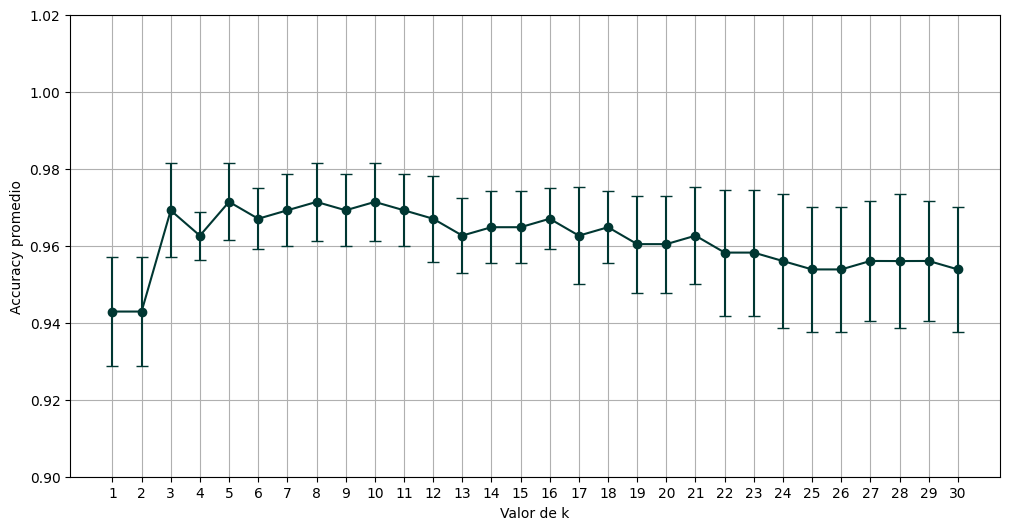

In [17]:
def stratified_k_fold(X, y, k=5, seed=40):
    np.random.seed(seed)
    y = np.array(y)
    unique_classes, y_indices = np.unique(y, return_inverse=True)
    
    # Índices de cada clase
    class_indices = [np.where(y_indices == i)[0] for i in range(len(unique_classes))]
    for ci in class_indices:
        np.random.shuffle(ci)

    # Crear folds
    folds = [[] for _ in range(k)]
    for ci in class_indices:
        fold_sizes = np.full(k, len(ci) // k, dtype=int)
        fold_sizes[: len(ci) % k] += 1
        current = 0
        for i in range(k):
            start, stop = current, current + fold_sizes[i]
            folds[i].extend(ci[start:stop])
            current = stop

    folds = [np.array(fold) for fold in folds]

    # Devuelve índices de train y val para cada fold
    for i in range(k):
        val_idx = folds[i]
        train_idx = np.concatenate([folds[j] for j in range(k) if j != i])
        yield train_idx, val_idx


def evaluar_weighted_knn_cv(X, y, valores_k, folds=5, seed=42):
    resultados_mean = {}
    resultados_std = {}

    for k in valores_k:
        accuracies = []

        for train_idx, val_idx in stratified_k_fold(X, y, k=folds, seed=seed):
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # Entrena el modelo
            knn = WeightedKnnClassif(k=k)
            knn.fit(X_train_fold, y_train_fold)
            y_pred = knn.predict(X_val_fold)

            # Accuracy
            acc = np.mean(y_pred == y_val_fold)
            accuracies.append(acc)

        resultados_mean[k] = np.mean(accuracies)
        resultados_std[k] = np.std(accuracies, ddof=1)

    return resultados_mean, resultados_std

resultados_mean, resultados_std = evaluar_weighted_knn_cv(
    X_train_scaled, y_train, list(range(1, 31))
)

ks = np.array(sorted(resultados_mean.keys()))
accuracies_mean = np.array([resultados_mean[k] for k in ks])
accuracies_std = np.array([resultados_std[k] for k in ks])

plt.figure(figsize=(12, 6))
plt.errorbar(
    ks, accuracies_mean, yerr=accuracies_std,
    fmt='o-', color='#003732', ecolor='#003732', capsize=4
)
#plt.title("Curva de Validación - Weighted k-NN (k = 1 a 30)")
plt.xlabel("Valor de k")
plt.ylabel("Accuracy promedio")
plt.grid(True)
plt.xticks(ks)
plt.ylim(0.9, 1.02)
plt.show()
